<a href="https://colab.research.google.com/github/raulcho94527/080223/blob/master/%5Byscho%5DL0basedSCCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#criterion
import torch
import torch.nn as nn


def cov(x, y):
    x_bar = x - x.mean(axis=0)
    y_bar = y - y.mean(axis=0)
    N = x_bar.shape[0]
    return (y_bar.T @ x_bar).T / (N - 1)


class NegCorr(nn.Module):
    def __init__(self, device, eps=1e-5):
        super(NegCorr, self).__init__()
        self.device = device
        self.eps = eps

    def forward(self, x, y):
        C_yy = cov(y, y)
        C_yx = cov(y, x)
        C_xx = cov(x, x)

        C_yy = C_yy + torch.eye(C_yy.shape[0], device=self.device) * self.eps
        C_xx = C_xx + torch.eye(C_xx.shape[0], device=self.device) * self.eps

        M = torch.linalg.multi_dot([torch.inverse(C_yy),    #yy의인버스
                                    C_yx,
                                    torch.inverse(C_xx),
                                    C_yx.T])
        return -torch.trace(M) # Returns the sum of the elements of the diagonal of the input 2-D matrix.


In [15]:
#STG
import torch
import torch.nn as nn
import math


class StochasticGates(nn.Module):
    def __init__(self, size, sigma, lam, gate_init=None):
        super().__init__()
        self.size = size
        if gate_init is None:
            mus = 1.0 * torch.ones(size) #torch.ones: 1로 가득찬 size의 matrix반환
        else:
            mus = torch.from_numpy(gate_init)
        self.mus = nn.Parameter(mus, requires_grad=True)
        self.sigma = sigma
        self.lam = lam

    def forward(self, x):
        gaussian = self.sigma * torch.randn(self.mus.size()) * self.training
        shifted_gaussian = self.mus + gaussian.to(x.device)
        z = torch.clamp(shifted_gaussian, 0.0, 1.0)
        new_x = x * z
        return new_x

    def get_reg(self):
        return self.lam * torch.sum((1 + torch.erf((self.mus / self.sigma) / math.sqrt(2))) / 2) #  

    def get_gates(self):
        return torch.clamp(self.mus, 0.0, 1.0)


In [17]:
#SDCCA

import torch.nn as nn
# from STG import StochasticGates


class SDCCA(nn.Module):
    def __init__(self, x_size, f, lamx, sigmax,
                       y_size, g, lamy, sigmay):
        super().__init__()
        self.gated_f = nn.Sequential(
            StochasticGates(x_size, sigmax, lamx),
            f)
        self.gated_g = nn.Sequential(
            StochasticGates(y_size, sigmay, lamy),
            g)

    def forward(self, X, Y):
        return self.gated_f(X), self.gated_g(Y)

    def get_reg(self):
        return self.gated_f[0].get_reg().mean() + self.gated_g[0].get_reg().mean()

    def get_gates(self):
        """
        use this function to retrieve the gates values for each modality
        :return: gates values
        """
        return self.gated_f[0].get_gates(), self.gated_g[0].get_gates()

    def get_function_parameters(self):
        """
        use this function if you wish to use a different optimizer for functions and gates
        :return: learnable parameters of f and g
        """
        params = list()
        for function in [self.gated_f, self.gated_g]:
            params += list(function[1].parameters())
        return params

    def get_gates_parameters(self):
        """
        use this function if you wish to use a different optimizer for functions and gates
        :return: learnable parameters of the gates
        """
        params = list()
        for function in [self.gated_f, self.gated_g]:
            params += list(function[0].parameters())
        return params


In [18]:
#utils.py

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


def gen_data(n=400, p=800, q=800, rho=0.9, flag=0, fac=1):
    Sigma_x = 1 * np.eye(p)
    Sigma_y = 1 * np.eye(q)
    Sigma_0 = 1 * np.eye(p)
    if flag == 1:
        for i in range(p):
            for j in range(p):
                Sigma_x[i, j] = 0.9 ** (abs(i - j))
    elif flag == 2:
        for i in range(p):
            for j in range(p):
                if np.abs(i - j) == 1:
                    Sigma_0[i, j] = 0.5
                elif np.abs(i - j) == 2:
                    Sigma_0[i, j] = 0.4
        Sigma_1 = np.copy(np.linalg.inv(Sigma_0))
        Sigma_x = np.copy(Sigma_1)
        for i in range(p):
            for j in range(p):
                Sigma_x[i, j] = Sigma_1[i, j] / (np.sqrt(Sigma_1[i, i] * Sigma_1[j, j]))

    Sigma_y = Sigma_x

    k = 5
    not_valid = True
    while not_valid:
        u = np.zeros((p, 1))
        v = np.zeros((q, 1))
        ind1 = np.random.choice(np.arange(p), k)
        ind2 = np.random.choice(np.arange(q), k)
        u[ind1] = fac / np.sqrt(k)
        v[ind2] = fac / np.sqrt(k)
        Sigma_xy = rho * Sigma_x @ u @ v.T @ Sigma_y
        Sigma1 = np.hstack((Sigma_x, Sigma_xy))
        Sigma2 = np.hstack((Sigma_xy.T, Sigma_y))
        Sigma = np.vstack((Sigma1, Sigma2))
        #    pos_def=is_pos_def(Sigma)
        #   if pos_def:
        not_valid = False
        if sum(u != 0) != k or sum(v != 0) != k:
            print('problems with u or v')
            not_valid = True
        try:
            xy = np.random.multivariate_normal(np.zeros(Sigma.shape[0]), Sigma, n, check_valid='raise')
        except:
            print('Cov not valid')
            not_valid = True

    x = xy[:, :p]
    y = xy[:, p:]
    return x, y, u, v, Sigma_xy


class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm, self).__init__()

    def forward(self, x):
        return nn.functional.normalize(x, dim=-1)


def plot_gates(net, name, u, v):
    g_x, g_y = net.get_gates()
    g_x = g_x.cpu().detach().numpy().T
    g_y = g_y.cpu().detach().numpy().T

    plt.subplot(2, 1, 1)
    plt.stem(u, basefmt=" ", markerfmt='D')
    plt.stem(g_x, basefmt=" ", linefmt='r')
    plt.title(f'x gates')

    plt.subplot(2, 1, 2)
    plt.stem(v, basefmt=" ", markerfmt='D')
    plt.stem(g_y, basefmt=" ", linefmt='r')
    plt.title(f'y gates')

    plt.suptitle(f'{name}')
    plt.show()
    plt.close()

problems with u or v
problems with u or v
Epoch[100/50000]: corr: 0.5230438113212585, reg: 1.2675261497497559
Epoch[200/50000]: corr: 0.4190612733364105, reg: 0.7981694936752319
Epoch[300/50000]: corr: 0.7878276109695435, reg: 0.5658310651779175
Epoch[400/50000]: corr: 1.2100882530212402, reg: 0.5098565816879272
Epoch[500/50000]: corr: 2.5645182132720947, reg: 0.5033168792724609
Epoch[600/50000]: corr: 3.397922992706299, reg: 0.502350926399231
Epoch[700/50000]: corr: 3.168776273727417, reg: 0.5031664371490479
Epoch[800/50000]: corr: 4.427036285400391, reg: 0.5026415586471558
Epoch[900/50000]: corr: 5.901253700256348, reg: 0.5026165246963501
Epoch[1000/50000]: corr: 6.410696506500244, reg: 0.5023248195648193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

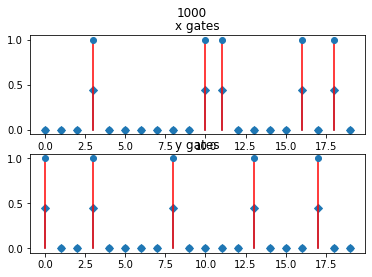

Epoch[1100/50000]: corr: 6.7759199142456055, reg: 0.501980185508728
Epoch[1200/50000]: corr: 7.213217258453369, reg: 0.501787006855011
Epoch[1300/50000]: corr: 7.625885486602783, reg: 0.5016892552375793
Epoch[1400/50000]: corr: 3.348327875137329, reg: 0.5015630125999451
Epoch[1500/50000]: corr: 8.335054397583008, reg: 0.5014665126800537
Epoch[1600/50000]: corr: 8.607980728149414, reg: 0.5013675093650818
Epoch[1700/50000]: corr: 8.803657531738281, reg: 0.501144528388977
Epoch[1800/50000]: corr: 8.955565452575684, reg: 0.5009424686431885
Epoch[1900/50000]: corr: 9.113286018371582, reg: 0.5008754730224609
Epoch[2000/50000]: corr: 9.208578109741211, reg: 0.5008491277694702


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

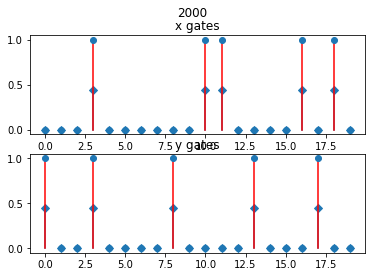

Epoch[2100/50000]: corr: 9.338945388793945, reg: 0.5008493661880493
Epoch[2200/50000]: corr: 9.365192413330078, reg: 0.5008091926574707
Epoch[2300/50000]: corr: 9.478334426879883, reg: 0.5006681680679321
Epoch[2400/50000]: corr: 9.498517036437988, reg: 0.5006038546562195
Epoch[2500/50000]: corr: 9.577174186706543, reg: 0.500568151473999
Epoch[2600/50000]: corr: 9.58452033996582, reg: 0.5005290508270264
Epoch[2700/50000]: corr: 9.644323348999023, reg: 0.5004886984825134
Epoch[2800/50000]: corr: 9.680594444274902, reg: 0.5004520416259766
Epoch[2900/50000]: corr: 9.708873748779297, reg: 0.5004324913024902
Epoch[3000/50000]: corr: 9.73556900024414, reg: 0.5004165172576904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

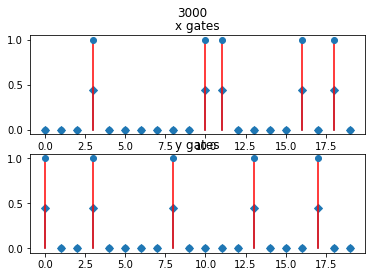

Epoch[3100/50000]: corr: 9.762550354003906, reg: 0.5004056096076965
Epoch[3200/50000]: corr: 9.793790817260742, reg: 0.5003975629806519
Epoch[3300/50000]: corr: 9.811209678649902, reg: 0.5003859400749207
Epoch[3400/50000]: corr: 9.816871643066406, reg: 0.5003747940063477
Epoch[3500/50000]: corr: 9.845253944396973, reg: 0.500338077545166
Epoch[3600/50000]: corr: 9.807924270629883, reg: 0.5003323554992676
Epoch[3700/50000]: corr: 9.844691276550293, reg: 0.500325083732605
Epoch[3800/50000]: corr: 9.874283790588379, reg: 0.5003238916397095
Epoch[3900/50000]: corr: 9.85321044921875, reg: 0.5003162622451782
Epoch[4000/50000]: corr: 9.890973091125488, reg: 0.5003087520599365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

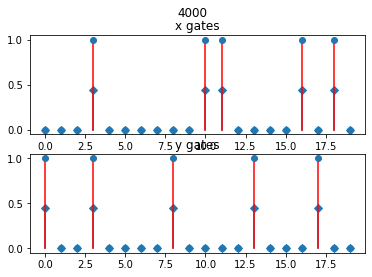

Epoch[4100/50000]: corr: 9.896224021911621, reg: 0.5003016591072083
Epoch[4200/50000]: corr: 9.903838157653809, reg: 0.5002949237823486
Epoch[4300/50000]: corr: 9.905838966369629, reg: 0.5002803802490234
Epoch[4400/50000]: corr: 9.913811683654785, reg: 0.5002732872962952
Epoch[4500/50000]: corr: 9.917776107788086, reg: 0.5002675652503967
Epoch[4600/50000]: corr: 9.921119689941406, reg: 0.5002625584602356
Epoch[4700/50000]: corr: 9.924811363220215, reg: 0.5002573728561401
Epoch[4800/50000]: corr: 9.927608489990234, reg: 0.500252366065979
Epoch[4900/50000]: corr: 9.929569244384766, reg: 0.500247597694397
Epoch[5000/50000]: corr: 9.930665969848633, reg: 0.5002428293228149


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

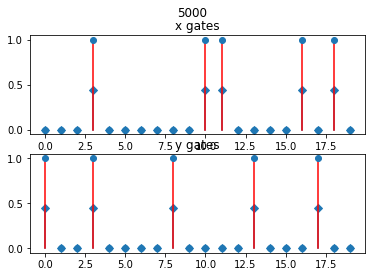

Epoch[5100/50000]: corr: 9.936018943786621, reg: 0.5002383589744568
Epoch[5200/50000]: corr: 9.938591003417969, reg: 0.5002341270446777
Epoch[5300/50000]: corr: 9.94095230102539, reg: 0.5002298355102539
Epoch[5400/50000]: corr: 9.943072319030762, reg: 0.5002259016036987
Epoch[5500/50000]: corr: 9.943164825439453, reg: 0.5002219676971436
Epoch[5600/50000]: corr: 9.94669246673584, reg: 0.5002181529998779
Epoch[5700/50000]: corr: 9.948548316955566, reg: 0.5002145171165466
Epoch[5800/50000]: corr: 9.949851036071777, reg: 0.5001958608627319
Epoch[5900/50000]: corr: 9.951493263244629, reg: 0.5001924633979797
Epoch[6000/50000]: corr: 9.947101593017578, reg: 0.5001893043518066


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

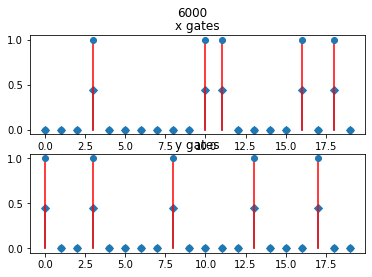

Epoch[6100/50000]: corr: 9.891000747680664, reg: 0.5001862049102783
Epoch[6200/50000]: corr: 9.954963684082031, reg: 0.5001832246780396
Epoch[6300/50000]: corr: 9.9488525390625, reg: 0.5001804232597351
Epoch[6400/50000]: corr: 9.95581340789795, reg: 0.5001776218414307
Epoch[6500/50000]: corr: 9.957610130310059, reg: 0.500174880027771
Epoch[6600/50000]: corr: 9.958700180053711, reg: 0.5001721978187561
Epoch[6700/50000]: corr: 9.959686279296875, reg: 0.5001696944236755
Epoch[6800/50000]: corr: 9.942789077758789, reg: 0.5001671314239502
Epoch[6900/50000]: corr: 9.96133041381836, reg: 0.5001646280288696
Epoch[7000/50000]: corr: 9.962224006652832, reg: 0.5001622438430786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

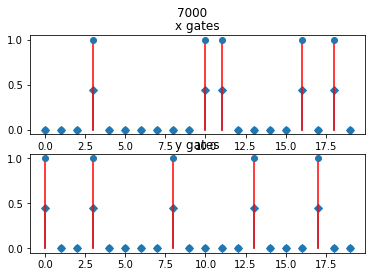

Epoch[7100/50000]: corr: 9.961724281311035, reg: 0.5001599788665771
Epoch[7200/50000]: corr: 9.963234901428223, reg: 0.5001577138900757
Epoch[7300/50000]: corr: 9.963995933532715, reg: 0.5001554489135742
Epoch[7400/50000]: corr: 9.961030960083008, reg: 0.5001533031463623
Epoch[7500/50000]: corr: 9.960225105285645, reg: 0.5001512765884399
Epoch[7600/50000]: corr: 9.966146469116211, reg: 0.5001493096351624
Epoch[7700/50000]: corr: 9.966906547546387, reg: 0.5001472234725952
Epoch[7800/50000]: corr: 9.966207504272461, reg: 0.5001453161239624
Epoch[7900/50000]: corr: 9.967803955078125, reg: 0.5001434087753296
Epoch[8000/50000]: corr: 9.968419075012207, reg: 0.5001415610313416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

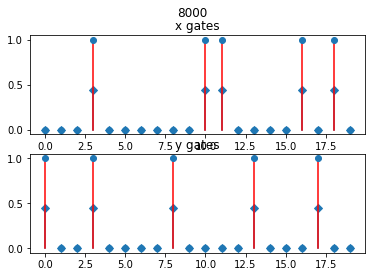

Epoch[8100/50000]: corr: 9.966117858886719, reg: 0.5001397132873535
Epoch[8200/50000]: corr: 9.937775611877441, reg: 0.5001380443572998
Epoch[8300/50000]: corr: 9.96967887878418, reg: 0.5001362562179565
Epoch[8400/50000]: corr: 9.969823837280273, reg: 0.5001394748687744
Epoch[8500/50000]: corr: 9.97053050994873, reg: 0.5001378059387207
Epoch[8600/50000]: corr: 9.971012115478516, reg: 0.5001362562179565
Epoch[8700/50000]: corr: 9.971455574035645, reg: 0.5001346468925476
Epoch[8800/50000]: corr: 9.971771240234375, reg: 0.5001330971717834
Epoch[8900/50000]: corr: 9.972053527832031, reg: 0.5001316070556641
Epoch[9000/50000]: corr: 9.972044944763184, reg: 0.5001300573348999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

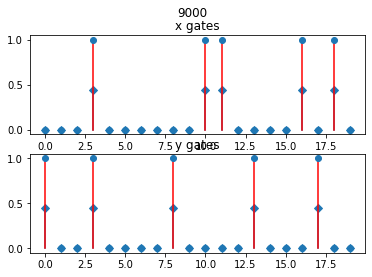

Epoch[9100/50000]: corr: 9.972454071044922, reg: 0.5001286864280701
Epoch[9200/50000]: corr: 9.972785949707031, reg: 0.5001273155212402
Epoch[9300/50000]: corr: 9.972622871398926, reg: 0.5001258850097656
Epoch[9400/50000]: corr: 9.97352409362793, reg: 0.5001245737075806
Epoch[9500/50000]: corr: 9.973928451538086, reg: 0.5001232028007507
Epoch[9600/50000]: corr: 9.974266052246094, reg: 0.5001219511032104
Epoch[9700/50000]: corr: 9.971786499023438, reg: 0.5001205801963806
Epoch[9800/50000]: corr: 9.973779678344727, reg: 0.5001194477081299
Epoch[9900/50000]: corr: 9.974884033203125, reg: 0.5001181960105896
Epoch[10000/50000]: corr: 9.974166870117188, reg: 0.5001170039176941


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

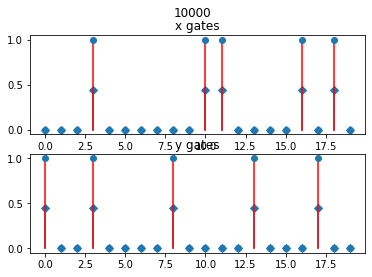

Epoch[10100/50000]: corr: 9.975415229797363, reg: 0.5001158118247986
Epoch[10200/50000]: corr: 9.967041015625, reg: 0.5001146793365479
Epoch[10300/50000]: corr: 9.975554466247559, reg: 0.5001134872436523
Epoch[10400/50000]: corr: 9.975908279418945, reg: 0.5001124143600464
Epoch[10500/50000]: corr: 9.97617244720459, reg: 0.5001112818717957
Epoch[10600/50000]: corr: 9.975607872009277, reg: 0.5001102685928345
Epoch[10700/50000]: corr: 9.974940299987793, reg: 0.5001091361045837
Epoch[10800/50000]: corr: 9.973958015441895, reg: 0.5001081228256226
Epoch[10900/50000]: corr: 9.976480484008789, reg: 0.5001070499420166
Epoch[11000/50000]: corr: 9.977095603942871, reg: 0.5001060962677002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

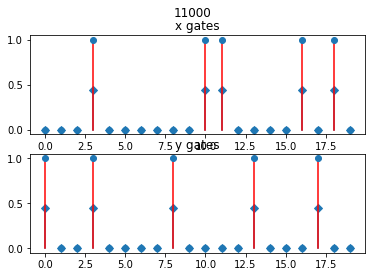

Epoch[11100/50000]: corr: 9.974834442138672, reg: 0.5001051425933838
Epoch[11200/50000]: corr: 9.977500915527344, reg: 0.5001041889190674
Epoch[11300/50000]: corr: 9.976388931274414, reg: 0.500103235244751
Epoch[11400/50000]: corr: 9.9760160446167, reg: 0.5001022219657898
Epoch[11500/50000]: corr: 9.977946281433105, reg: 0.5001013278961182
Epoch[11600/50000]: corr: 9.978169441223145, reg: 0.5001003742218018
Epoch[11700/50000]: corr: 9.978050231933594, reg: 0.5000929832458496
Epoch[11800/50000]: corr: 9.978421211242676, reg: 0.5000921487808228
Epoch[11900/50000]: corr: 9.978110313415527, reg: 0.5000912547111511
Epoch[12000/50000]: corr: 9.978485107421875, reg: 0.500090479850769


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

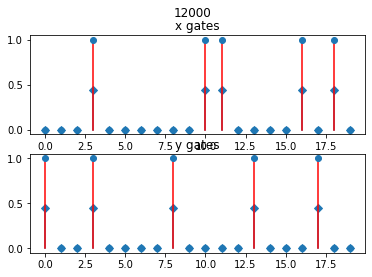

Epoch[12100/50000]: corr: 9.953417778015137, reg: 0.5000780820846558
Epoch[12200/50000]: corr: 9.978857040405273, reg: 0.5000755190849304
Epoch[12300/50000]: corr: 9.979097366333008, reg: 0.5000747442245483
Epoch[12400/50000]: corr: 9.97927474975586, reg: 0.5000741481781006
Epoch[12500/50000]: corr: 9.979235649108887, reg: 0.5000733733177185
Epoch[12600/50000]: corr: 9.979569435119629, reg: 0.500072717666626
Epoch[12700/50000]: corr: 9.975019454956055, reg: 0.5000720024108887
Epoch[12800/50000]: corr: 9.978975296020508, reg: 0.5000714063644409
Epoch[12900/50000]: corr: 9.97693920135498, reg: 0.5000706911087036
Epoch[13000/50000]: corr: 9.977289199829102, reg: 0.5000700354576111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

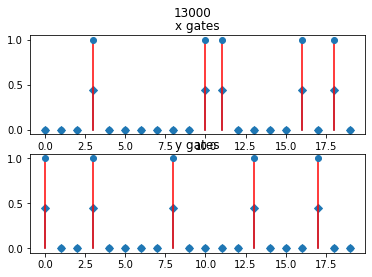

Epoch[13100/50000]: corr: 9.978586196899414, reg: 0.5000694394111633
Epoch[13200/50000]: corr: 9.975650787353516, reg: 0.5000686645507812
Epoch[13300/50000]: corr: 9.980530738830566, reg: 0.5000681281089783
Epoch[13400/50000]: corr: 9.980538368225098, reg: 0.5000674724578857
Epoch[13500/50000]: corr: 9.980181694030762, reg: 0.500066876411438
Epoch[13600/50000]: corr: 9.98043441772461, reg: 0.500066339969635
Epoch[13700/50000]: corr: 9.97752571105957, reg: 0.5000656843185425
Epoch[13800/50000]: corr: 9.980856895446777, reg: 0.5000650882720947
Epoch[13900/50000]: corr: 9.98122787475586, reg: 0.5000645518302917
Epoch[14000/50000]: corr: 9.981318473815918, reg: 0.5000640153884888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

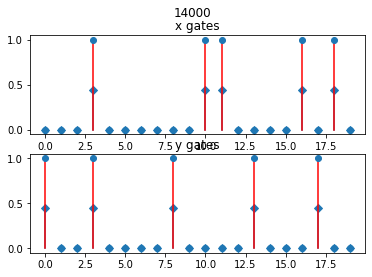

Epoch[14100/50000]: corr: 9.9813871383667, reg: 0.5000634789466858
Epoch[14200/50000]: corr: 9.979621887207031, reg: 0.5000629425048828
Epoch[14300/50000]: corr: 9.98149299621582, reg: 0.5000624060630798
Epoch[14400/50000]: corr: 9.97895336151123, reg: 0.5000619292259216
Epoch[14500/50000]: corr: 9.977299690246582, reg: 0.5000612735748291
Epoch[14600/50000]: corr: 9.981698036193848, reg: 0.5000608563423157
Epoch[14700/50000]: corr: 9.981901168823242, reg: 0.5000603199005127
Epoch[14800/50000]: corr: 9.980759620666504, reg: 0.5000597834587097
Epoch[14900/50000]: corr: 9.981888771057129, reg: 0.5000592470169067
Epoch[15000/50000]: corr: 9.982059478759766, reg: 0.5000588297843933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

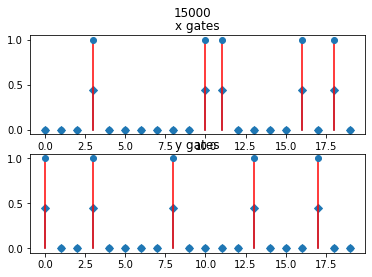

Epoch[15100/50000]: corr: 9.982183456420898, reg: 0.5000584125518799
Epoch[15200/50000]: corr: 9.981801986694336, reg: 0.5000579357147217
Epoch[15300/50000]: corr: 9.981437683105469, reg: 0.5000573396682739
Epoch[15400/50000]: corr: 9.97476577758789, reg: 0.5000569820404053
Epoch[15500/50000]: corr: 9.982220649719238, reg: 0.5000565052032471
Epoch[15600/50000]: corr: 9.982427597045898, reg: 0.5000560283660889
Epoch[15700/50000]: corr: 9.865249633789062, reg: 0.5000555515289307
Epoch[15800/50000]: corr: 9.982176780700684, reg: 0.500055193901062
Epoch[15900/50000]: corr: 9.808199882507324, reg: 0.5000547170639038
Epoch[16000/50000]: corr: 9.982001304626465, reg: 0.5000542998313904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

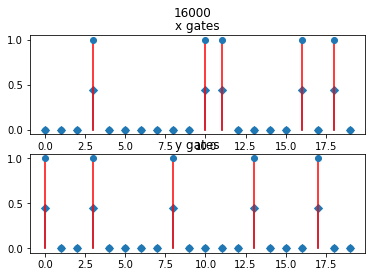

Epoch[16100/50000]: corr: 9.954367637634277, reg: 0.5000543594360352
Epoch[16200/50000]: corr: 9.982112884521484, reg: 0.5000540018081665
Epoch[16300/50000]: corr: 9.982390403747559, reg: 0.5000536441802979
Epoch[16400/50000]: corr: 9.98255443572998, reg: 0.5000532269477844
Epoch[16500/50000]: corr: 9.982682228088379, reg: 0.500052809715271
Epoch[16600/50000]: corr: 9.9827880859375, reg: 0.5000523924827576
Epoch[16700/50000]: corr: 9.970385551452637, reg: 0.5000520944595337
Epoch[16800/50000]: corr: 9.982736587524414, reg: 0.5000516772270203
Epoch[16900/50000]: corr: 9.982895851135254, reg: 0.5000512599945068
Epoch[17000/50000]: corr: 9.983004570007324, reg: 0.5000509023666382


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

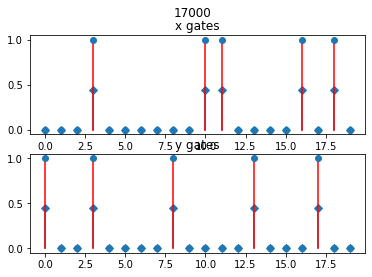

Epoch[17100/50000]: corr: 9.98307991027832, reg: 0.5000505447387695
Epoch[17200/50000]: corr: 9.983122825622559, reg: 0.5000501871109009
Epoch[17300/50000]: corr: 9.983216285705566, reg: 0.5000498294830322
Epoch[17400/50000]: corr: 9.983283996582031, reg: 0.5000494718551636
Epoch[17500/50000]: corr: 9.983288764953613, reg: 0.5000491142272949
Epoch[17600/50000]: corr: 9.983115196228027, reg: 0.5000487565994263
Epoch[17700/50000]: corr: 9.982146263122559, reg: 0.5000483989715576
Epoch[17800/50000]: corr: 9.982768058776855, reg: 0.500048041343689
Epoch[17900/50000]: corr: 9.983527183532715, reg: 0.5000476837158203
Epoch[18000/50000]: corr: 9.982369422912598, reg: 0.5000473856925964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

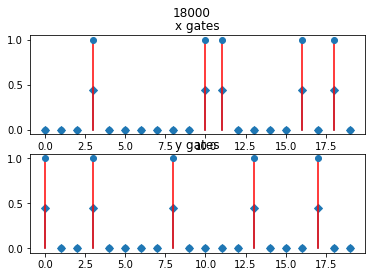

Epoch[18100/50000]: corr: 9.979074478149414, reg: 0.5000470876693726
Epoch[18200/50000]: corr: 9.98299503326416, reg: 0.5000467300415039
Epoch[18300/50000]: corr: 9.983774185180664, reg: 0.5000463724136353
Epoch[18400/50000]: corr: 9.978902816772461, reg: 0.5000460743904114
Epoch[18500/50000]: corr: 9.983891487121582, reg: 0.5000457763671875
Epoch[18600/50000]: corr: 9.984014511108398, reg: 0.5000454783439636
Epoch[18700/50000]: corr: 9.984099388122559, reg: 0.500045120716095
Epoch[18800/50000]: corr: 9.983434677124023, reg: 0.5000448226928711
Epoch[18900/50000]: corr: 9.984051704406738, reg: 0.500041663646698
Epoch[19000/50000]: corr: 9.984174728393555, reg: 0.5000413656234741


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

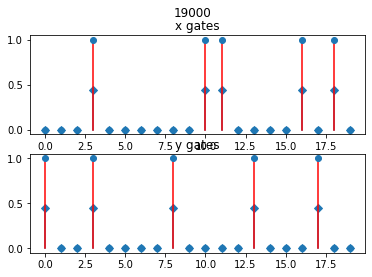

Epoch[19100/50000]: corr: 9.982604026794434, reg: 0.5000410079956055
Epoch[19200/50000]: corr: 9.984203338623047, reg: 0.5000407695770264
Epoch[19300/50000]: corr: 9.983407974243164, reg: 0.5000404715538025
Epoch[19400/50000]: corr: 9.984145164489746, reg: 0.5000402331352234
Epoch[19500/50000]: corr: 9.984283447265625, reg: 0.5000399351119995
Epoch[19600/50000]: corr: 9.984375, reg: 0.5000396370887756
Epoch[19700/50000]: corr: 9.984445571899414, reg: 0.5000393390655518
Epoch[19800/50000]: corr: 9.984511375427246, reg: 0.5000391006469727
Epoch[19900/50000]: corr: 9.980744361877441, reg: 0.500038743019104
Epoch[20000/50000]: corr: 9.983470916748047, reg: 0.5000385642051697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

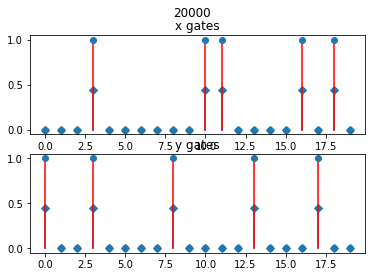

Epoch[20100/50000]: corr: 9.981017112731934, reg: 0.5000382661819458
Epoch[20200/50000]: corr: 9.984272956848145, reg: 0.5000380277633667
Epoch[20300/50000]: corr: 9.97972583770752, reg: 0.5000377893447876
Epoch[20400/50000]: corr: 9.97976016998291, reg: 0.5000375509262085
Epoch[20500/50000]: corr: 9.983123779296875, reg: 0.5000372529029846
Epoch[20600/50000]: corr: 9.98047161102295, reg: 0.5000370740890503
Epoch[20700/50000]: corr: 9.981497764587402, reg: 0.5000367760658264
Epoch[20800/50000]: corr: 9.98420238494873, reg: 0.5000365972518921
Epoch[20900/50000]: corr: 9.984753608703613, reg: 0.5000362992286682
Epoch[21000/50000]: corr: 9.982476234436035, reg: 0.5000361204147339


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

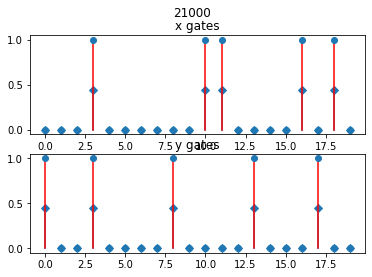

Epoch[21100/50000]: corr: 9.985177040100098, reg: 0.50003582239151
Epoch[21200/50000]: corr: 9.985172271728516, reg: 0.5000355839729309
Epoch[21300/50000]: corr: 9.98519229888916, reg: 0.5000354051589966
Epoch[21400/50000]: corr: 9.980783462524414, reg: 0.5000351071357727
Epoch[21500/50000]: corr: 9.983343124389648, reg: 0.5000348687171936
Epoch[21600/50000]: corr: 9.985092163085938, reg: 0.5000346899032593
Epoch[21700/50000]: corr: 9.985323905944824, reg: 0.5000344514846802
Epoch[21800/50000]: corr: 9.985079765319824, reg: 0.5000342130661011
Epoch[21900/50000]: corr: 9.983580589294434, reg: 0.500033974647522
Epoch[22000/50000]: corr: 9.985546112060547, reg: 0.5000337958335876


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

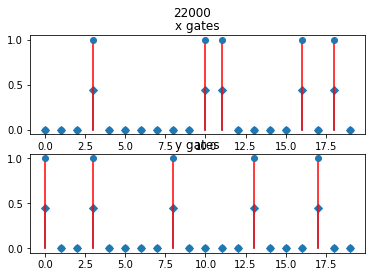

Epoch[22100/50000]: corr: 9.9848051071167, reg: 0.5000335574150085
Epoch[22200/50000]: corr: 9.984710693359375, reg: 0.5000333786010742
Epoch[22300/50000]: corr: 9.984545707702637, reg: 0.5000331997871399
Epoch[22400/50000]: corr: 9.983795166015625, reg: 0.500032901763916
Epoch[22500/50000]: corr: 9.981945037841797, reg: 0.5000327825546265
Epoch[22600/50000]: corr: 9.98165225982666, reg: 0.5000325441360474
Epoch[22700/50000]: corr: 9.985567092895508, reg: 0.5000323057174683
Epoch[22800/50000]: corr: 9.984170913696289, reg: 0.5000320672988892
Epoch[22900/50000]: corr: 9.9854097366333, reg: 0.5000319480895996
Epoch[23000/50000]: corr: 9.985899925231934, reg: 0.5000317096710205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

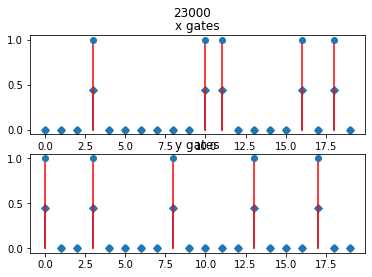

Epoch[23100/50000]: corr: 9.984436988830566, reg: 0.5000315308570862
Epoch[23200/50000]: corr: 9.984627723693848, reg: 0.5000313520431519
Epoch[23300/50000]: corr: 9.985910415649414, reg: 0.5000311136245728
Epoch[23400/50000]: corr: 9.986040115356445, reg: 0.5000309348106384
Epoch[23500/50000]: corr: 9.986112594604492, reg: 0.5000307559967041
Epoch[23600/50000]: corr: 9.98616886138916, reg: 0.5000305771827698
Epoch[23700/50000]: corr: 9.98614501953125, reg: 0.5000303983688354
Epoch[23800/50000]: corr: 9.986205101013184, reg: 0.5000301599502563
Epoch[23900/50000]: corr: 9.98603630065918, reg: 0.5000300407409668
Epoch[24000/50000]: corr: 9.98575496673584, reg: 0.5000298619270325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

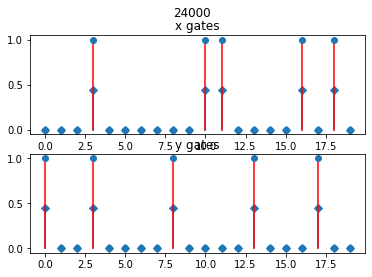

Epoch[24100/50000]: corr: 9.981184959411621, reg: 0.5000296831130981
Epoch[24200/50000]: corr: 9.985506057739258, reg: 0.5000295042991638
Epoch[24300/50000]: corr: 9.985809326171875, reg: 0.5000293254852295
Epoch[24400/50000]: corr: 9.978202819824219, reg: 0.5000291466712952
Epoch[24500/50000]: corr: 9.986207962036133, reg: 0.5000289678573608
Epoch[24600/50000]: corr: 9.985493659973145, reg: 0.5000287890434265
Epoch[24700/50000]: corr: 9.986380577087402, reg: 0.5000286102294922
Epoch[24800/50000]: corr: 9.985883712768555, reg: 0.5000284314155579
Epoch[24900/50000]: corr: 9.986424446105957, reg: 0.5000282526016235
Epoch[25000/50000]: corr: 9.986543655395508, reg: 0.500028133392334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

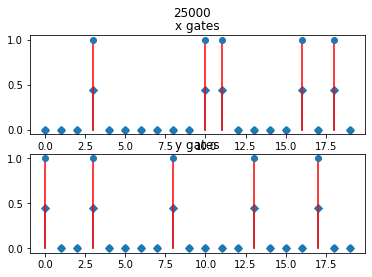

Epoch[25100/50000]: corr: 9.985411643981934, reg: 0.5000280141830444
Epoch[25200/50000]: corr: 9.986368179321289, reg: 0.5000277757644653
Epoch[25300/50000]: corr: 9.986597061157227, reg: 0.5000276565551758
Epoch[25400/50000]: corr: 9.985349655151367, reg: 0.5000274181365967
Epoch[25500/50000]: corr: 9.986306190490723, reg: 0.5000273585319519
Epoch[25600/50000]: corr: 9.983707427978516, reg: 0.5000271797180176
Epoch[25700/50000]: corr: 9.981276512145996, reg: 0.5000270009040833
Epoch[25800/50000]: corr: 9.986188888549805, reg: 0.5000268220901489
Epoch[25900/50000]: corr: 9.986078262329102, reg: 0.5000267028808594
Epoch[26000/50000]: corr: 9.985621452331543, reg: 0.5000265836715698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

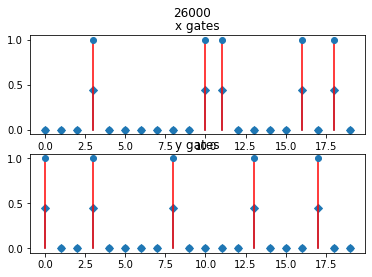

Epoch[26100/50000]: corr: 9.985958099365234, reg: 0.5000263452529907
Epoch[26200/50000]: corr: 9.986512184143066, reg: 0.500026285648346
Epoch[26300/50000]: corr: 9.986795425415039, reg: 0.5000260472297668
Epoch[26400/50000]: corr: 9.98689079284668, reg: 0.5000259876251221
Epoch[26500/50000]: corr: 9.986949920654297, reg: 0.500025749206543
Epoch[26600/50000]: corr: 9.98697566986084, reg: 0.5000256299972534
Epoch[26700/50000]: corr: 9.93332290649414, reg: 0.5000255107879639
Epoch[26800/50000]: corr: 9.986698150634766, reg: 0.5000253915786743
Epoch[26900/50000]: corr: 9.986875534057617, reg: 0.50002521276474
Epoch[27000/50000]: corr: 9.986956596374512, reg: 0.5000250339508057


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

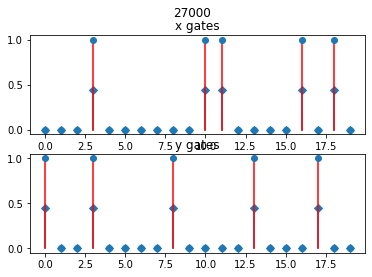

Epoch[27100/50000]: corr: 9.987018585205078, reg: 0.5000249147415161
Epoch[27200/50000]: corr: 9.987044334411621, reg: 0.5000248551368713
Epoch[27300/50000]: corr: 9.986883163452148, reg: 0.500024676322937
Epoch[27400/50000]: corr: 9.98704719543457, reg: 0.5000245571136475
Epoch[27500/50000]: corr: 9.985548973083496, reg: 0.5000244379043579
Epoch[27600/50000]: corr: 9.986748695373535, reg: 0.5000243186950684
Epoch[27700/50000]: corr: 9.987106323242188, reg: 0.500024139881134
Epoch[27800/50000]: corr: 9.986187934875488, reg: 0.5000240206718445
Epoch[27900/50000]: corr: 9.986454010009766, reg: 0.5000239014625549
Epoch[28000/50000]: corr: 9.984722137451172, reg: 0.5000237226486206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

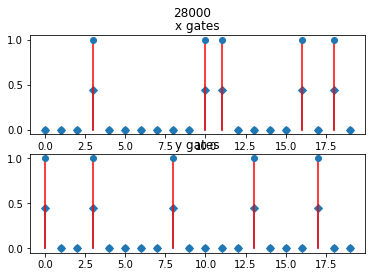

Epoch[28100/50000]: corr: 9.986710548400879, reg: 0.500023603439331
Epoch[28200/50000]: corr: 9.987127304077148, reg: 0.5000234842300415
Epoch[28300/50000]: corr: 9.98460578918457, reg: 0.500023365020752
Epoch[28400/50000]: corr: 9.986855506896973, reg: 0.5000232458114624
Epoch[28500/50000]: corr: 9.98704719543457, reg: 0.5000230669975281
Epoch[28600/50000]: corr: 9.987053871154785, reg: 0.5000230073928833
Epoch[28700/50000]: corr: 9.98698902130127, reg: 0.5000228881835938
Epoch[28800/50000]: corr: 9.985764503479004, reg: 0.5000227689743042
Epoch[28900/50000]: corr: 9.986769676208496, reg: 0.5000226497650146
Epoch[29000/50000]: corr: 9.987180709838867, reg: 0.5000225305557251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

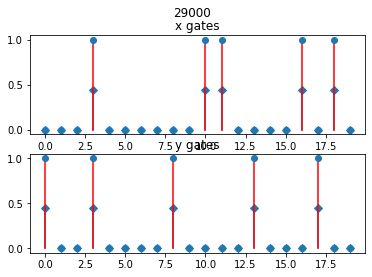

Epoch[29100/50000]: corr: 9.987178802490234, reg: 0.5000224113464355
Epoch[29200/50000]: corr: 9.984566688537598, reg: 0.500022292137146
Epoch[29300/50000]: corr: 9.986856460571289, reg: 0.5000221729278564
Epoch[29400/50000]: corr: 9.987266540527344, reg: 0.5000220537185669
Epoch[29500/50000]: corr: 9.987525939941406, reg: 0.5000219345092773
Epoch[29600/50000]: corr: 9.987435340881348, reg: 0.5000218152999878
Epoch[29700/50000]: corr: 9.987449645996094, reg: 0.5000216960906982
Epoch[29800/50000]: corr: 9.987504005432129, reg: 0.5000215768814087
Epoch[29900/50000]: corr: 9.986921310424805, reg: 0.5000214576721191
Epoch[30000/50000]: corr: 9.98745346069336, reg: 0.5000213384628296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

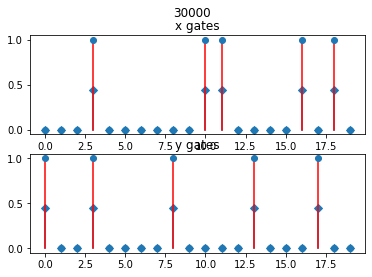

Epoch[30100/50000]: corr: 9.987639427185059, reg: 0.5000212788581848
Epoch[30200/50000]: corr: 9.985733985900879, reg: 0.5000211000442505
Epoch[30300/50000]: corr: 9.987116813659668, reg: 0.5000209808349609
Epoch[30400/50000]: corr: 9.73220157623291, reg: 0.5000208616256714
Epoch[30500/50000]: corr: 9.987381935119629, reg: 0.5000208020210266
Epoch[30600/50000]: corr: 9.987621307373047, reg: 0.5000207424163818
Epoch[30700/50000]: corr: 9.987646102905273, reg: 0.5000206232070923
Epoch[30800/50000]: corr: 9.987712860107422, reg: 0.5000205039978027
Epoch[30900/50000]: corr: 9.987767219543457, reg: 0.5000203847885132
Epoch[31000/50000]: corr: 9.987801551818848, reg: 0.5000202655792236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

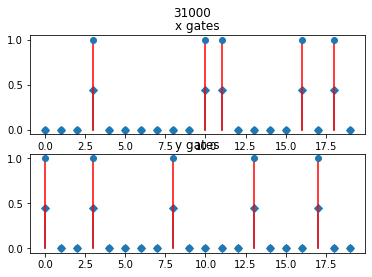

Epoch[31100/50000]: corr: 9.98781967163086, reg: 0.5000201463699341
Epoch[31200/50000]: corr: 9.98684024810791, reg: 0.5000200867652893
Epoch[31300/50000]: corr: 9.987709045410156, reg: 0.5000200271606445
Epoch[31400/50000]: corr: 9.987285614013672, reg: 0.500019907951355
Epoch[31500/50000]: corr: 9.984370231628418, reg: 0.5000197887420654
Epoch[31600/50000]: corr: 9.98708724975586, reg: 0.5000196695327759
Epoch[31700/50000]: corr: 9.987640380859375, reg: 0.5000196099281311
Epoch[31800/50000]: corr: 9.984766960144043, reg: 0.5000194311141968
Epoch[31900/50000]: corr: 9.987956047058105, reg: 0.500019371509552
Epoch[32000/50000]: corr: 9.987974166870117, reg: 0.5000192523002625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

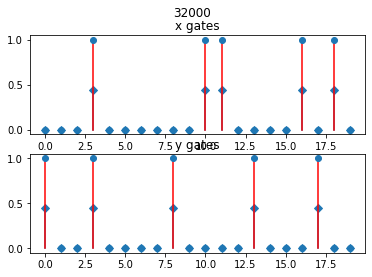

Epoch[32100/50000]: corr: 9.986091613769531, reg: 0.5000191926956177
Epoch[32200/50000]: corr: 9.987607955932617, reg: 0.5000191330909729
Epoch[32300/50000]: corr: 9.961333274841309, reg: 0.5000189542770386
Epoch[32400/50000]: corr: 9.98782730102539, reg: 0.5000188946723938
Epoch[32500/50000]: corr: 9.987948417663574, reg: 0.5000187754631042
Epoch[32600/50000]: corr: 9.98799991607666, reg: 0.5000187158584595
Epoch[32700/50000]: corr: 9.988040924072266, reg: 0.5000185966491699
Epoch[32800/50000]: corr: 9.98805046081543, reg: 0.5000185370445251
Epoch[32900/50000]: corr: 9.980422019958496, reg: 0.5000184178352356
Epoch[33000/50000]: corr: 9.98806095123291, reg: 0.5000183582305908


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

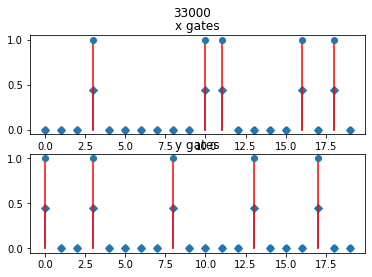

Epoch[33100/50000]: corr: 9.977860450744629, reg: 0.5000182390213013
Epoch[33200/50000]: corr: 9.987858772277832, reg: 0.5000182390213013
Epoch[33300/50000]: corr: 9.987859725952148, reg: 0.5000180006027222
Epoch[33400/50000]: corr: 9.987919807434082, reg: 0.5000180006027222
Epoch[33500/50000]: corr: 9.988146781921387, reg: 0.5000179409980774
Epoch[33600/50000]: corr: 9.987704277038574, reg: 0.5000178217887878
Epoch[33700/50000]: corr: 9.987811088562012, reg: 0.5000177621841431
Epoch[33800/50000]: corr: 9.987260818481445, reg: 0.5000176429748535
Epoch[33900/50000]: corr: 9.986355781555176, reg: 0.5000175833702087
Epoch[34000/50000]: corr: 9.988066673278809, reg: 0.5000174641609192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

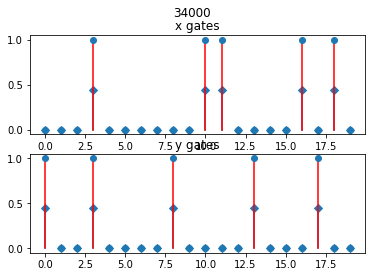

Epoch[34100/50000]: corr: 9.98808479309082, reg: 0.5000174045562744
Epoch[34200/50000]: corr: 9.988258361816406, reg: 0.5000172853469849
Epoch[34300/50000]: corr: 9.979546546936035, reg: 0.5000172257423401
Epoch[34400/50000]: corr: 9.984987258911133, reg: 0.5000171065330505
Epoch[34500/50000]: corr: 9.988191604614258, reg: 0.5000170469284058
Epoch[34600/50000]: corr: 9.986342430114746, reg: 0.500016987323761
Epoch[34700/50000]: corr: 9.988321304321289, reg: 0.5000169277191162
Epoch[34800/50000]: corr: 9.979849815368652, reg: 0.5000168085098267
Epoch[34900/50000]: corr: 9.986720085144043, reg: 0.5000166893005371
Epoch[35000/50000]: corr: 9.988354682922363, reg: 0.5000166296958923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

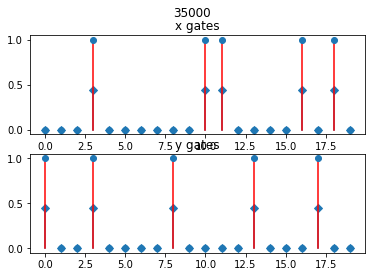

Epoch[35100/50000]: corr: 9.986954689025879, reg: 0.5000165700912476
Epoch[35200/50000]: corr: 9.988353729248047, reg: 0.500016450881958
Epoch[35300/50000]: corr: 9.988394737243652, reg: 0.500016450881958
Epoch[35400/50000]: corr: 9.987693786621094, reg: 0.5000163316726685
Epoch[35500/50000]: corr: 9.98793888092041, reg: 0.5000162720680237
Epoch[35600/50000]: corr: 9.987120628356934, reg: 0.5000162124633789
Epoch[35700/50000]: corr: 9.988371849060059, reg: 0.5000160932540894
Epoch[35800/50000]: corr: 9.98818588256836, reg: 0.5000160336494446
Epoch[35900/50000]: corr: 9.987798690795898, reg: 0.5000159740447998
Epoch[36000/50000]: corr: 9.987360954284668, reg: 0.5000158548355103


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

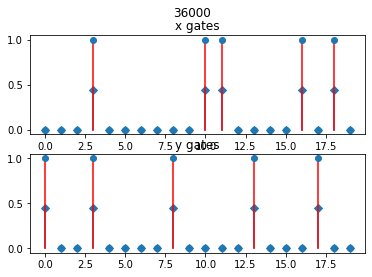

Epoch[36100/50000]: corr: 9.988091468811035, reg: 0.5000158548355103
Epoch[36200/50000]: corr: 9.986767768859863, reg: 0.5000157356262207
Epoch[36300/50000]: corr: 9.988390922546387, reg: 0.5000156760215759
Epoch[36400/50000]: corr: 9.988374710083008, reg: 0.5000156164169312
Epoch[36500/50000]: corr: 9.986893653869629, reg: 0.5000154972076416
Epoch[36600/50000]: corr: 9.98843002319336, reg: 0.5000154972076416
Epoch[36700/50000]: corr: 9.987626075744629, reg: 0.500015377998352
Epoch[36800/50000]: corr: 9.988624572753906, reg: 0.5000152587890625
Epoch[36900/50000]: corr: 9.976346015930176, reg: 0.5000152587890625
Epoch[37000/50000]: corr: 9.987398147583008, reg: 0.5000151991844177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

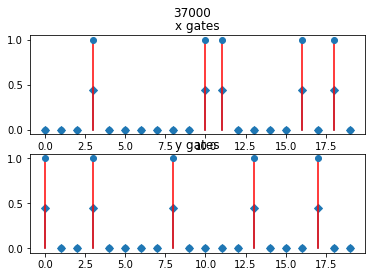

Epoch[37100/50000]: corr: 9.98864459991455, reg: 0.500015139579773
Epoch[37200/50000]: corr: 9.988698959350586, reg: 0.5000150203704834
Epoch[37300/50000]: corr: 9.988593101501465, reg: 0.5000150203704834
Epoch[37400/50000]: corr: 9.98867130279541, reg: 0.5000149011611938
Epoch[37500/50000]: corr: 9.988412857055664, reg: 0.5000148415565491
Epoch[37600/50000]: corr: 9.98869800567627, reg: 0.5000147819519043
Epoch[37700/50000]: corr: 9.988737106323242, reg: 0.5000146627426147
Epoch[37800/50000]: corr: 9.988748550415039, reg: 0.5000146627426147
Epoch[37900/50000]: corr: 9.986725807189941, reg: 0.5000145435333252
Epoch[38000/50000]: corr: 9.988625526428223, reg: 0.5000144243240356


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

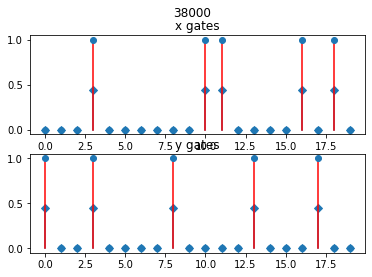

Epoch[38100/50000]: corr: 9.986625671386719, reg: 0.5000144243240356
Epoch[38200/50000]: corr: 9.988670349121094, reg: 0.5000144243240356
Epoch[38300/50000]: corr: 9.988207817077637, reg: 0.5000143051147461
Epoch[38400/50000]: corr: 9.988701820373535, reg: 0.5000142455101013
Epoch[38500/50000]: corr: 9.988625526428223, reg: 0.5000141859054565
Epoch[38600/50000]: corr: 9.987930297851562, reg: 0.5000141263008118
Epoch[38700/50000]: corr: 9.9866304397583, reg: 0.500014066696167
Epoch[38800/50000]: corr: 9.98880386352539, reg: 0.5000139474868774
Epoch[38900/50000]: corr: 9.987408638000488, reg: 0.5000139474868774
Epoch[39000/50000]: corr: 9.987324714660645, reg: 0.5000138282775879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

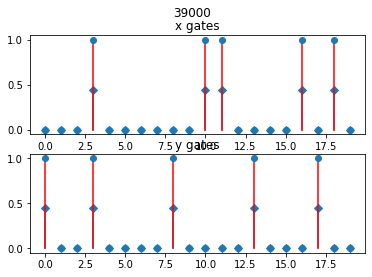

Epoch[39100/50000]: corr: 9.988475799560547, reg: 0.5000138282775879
Epoch[39200/50000]: corr: 9.98882007598877, reg: 0.5000137090682983
Epoch[39300/50000]: corr: 9.988515853881836, reg: 0.5000136494636536
Epoch[39400/50000]: corr: 9.987081527709961, reg: 0.5000135898590088
Epoch[39500/50000]: corr: 9.988702774047852, reg: 0.5000135898590088
Epoch[39600/50000]: corr: 9.967730522155762, reg: 0.5000135898590088
Epoch[39700/50000]: corr: 9.988826751708984, reg: 0.5000134706497192
Epoch[39800/50000]: corr: 9.98888111114502, reg: 0.5000133514404297
Epoch[39900/50000]: corr: 9.988917350769043, reg: 0.5000132918357849
Epoch[40000/50000]: corr: 9.98857593536377, reg: 0.5000132918357849


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

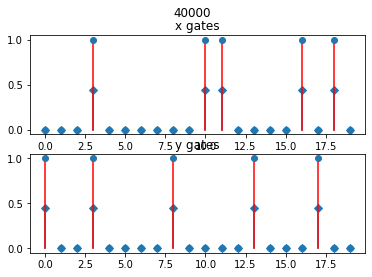

Epoch[40100/50000]: corr: 9.986281394958496, reg: 0.5000132322311401
Epoch[40200/50000]: corr: 9.98600959777832, reg: 0.5000131726264954
Epoch[40300/50000]: corr: 9.981919288635254, reg: 0.5000131130218506
Epoch[40400/50000]: corr: 9.988237380981445, reg: 0.500012993812561
Epoch[40500/50000]: corr: 9.987889289855957, reg: 0.500012993812561
Epoch[40600/50000]: corr: 9.988419532775879, reg: 0.5000128746032715
Epoch[40700/50000]: corr: 9.9888916015625, reg: 0.5000128746032715
Epoch[40800/50000]: corr: 9.988890647888184, reg: 0.5000128149986267
Epoch[40900/50000]: corr: 9.9887113571167, reg: 0.5000127553939819
Epoch[41000/50000]: corr: 9.988451957702637, reg: 0.5000126957893372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

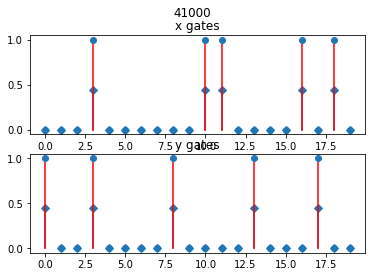

Epoch[41100/50000]: corr: 9.988683700561523, reg: 0.5000126361846924
Epoch[41200/50000]: corr: 9.988815307617188, reg: 0.5000125169754028
Epoch[41300/50000]: corr: 9.987491607666016, reg: 0.5000125169754028
Epoch[41400/50000]: corr: 9.989103317260742, reg: 0.5000125169754028
Epoch[41500/50000]: corr: 9.986409187316895, reg: 0.5000124573707581
Epoch[41600/50000]: corr: 9.98896598815918, reg: 0.5000123977661133
Epoch[41700/50000]: corr: 9.989055633544922, reg: 0.5000123381614685
Epoch[41800/50000]: corr: 9.989100456237793, reg: 0.5000122785568237
Epoch[41900/50000]: corr: 9.989065170288086, reg: 0.500012218952179
Epoch[42000/50000]: corr: 9.989116668701172, reg: 0.5000121593475342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

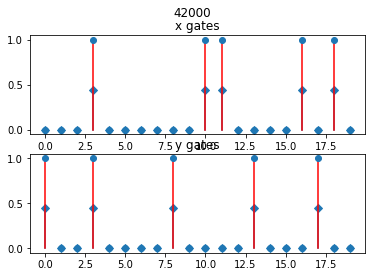

Epoch[42100/50000]: corr: 9.988887786865234, reg: 0.5000120997428894
Epoch[42200/50000]: corr: 9.98911190032959, reg: 0.5000120401382446
Epoch[42300/50000]: corr: 9.989026069641113, reg: 0.5000120401382446
Epoch[42400/50000]: corr: 9.989078521728516, reg: 0.5000119209289551
Epoch[42500/50000]: corr: 9.989068984985352, reg: 0.5000119209289551
Epoch[42600/50000]: corr: 9.98757266998291, reg: 0.5000118613243103
Epoch[42700/50000]: corr: 9.987594604492188, reg: 0.5000118613243103
Epoch[42800/50000]: corr: 9.988808631896973, reg: 0.5000118017196655
Epoch[42900/50000]: corr: 9.987445831298828, reg: 0.500011682510376
Epoch[43000/50000]: corr: 9.985335350036621, reg: 0.500011682510376


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

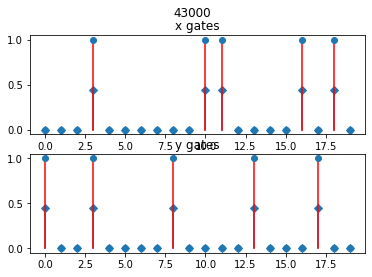

Epoch[43100/50000]: corr: 9.989152908325195, reg: 0.5000116229057312
Epoch[43200/50000]: corr: 9.988906860351562, reg: 0.5000115633010864
Epoch[43300/50000]: corr: 9.988607406616211, reg: 0.5000115633010864
Epoch[43400/50000]: corr: 9.988550186157227, reg: 0.5000114440917969
Epoch[43500/50000]: corr: 9.98920726776123, reg: 0.5000114440917969
Epoch[43600/50000]: corr: 9.988083839416504, reg: 0.5000113844871521
Epoch[43700/50000]: corr: 9.989089012145996, reg: 0.5000113248825073
Epoch[43800/50000]: corr: 9.989178657531738, reg: 0.5000112652778625
Epoch[43900/50000]: corr: 9.98906135559082, reg: 0.5000112056732178
Epoch[44000/50000]: corr: 9.989242553710938, reg: 0.500011146068573


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

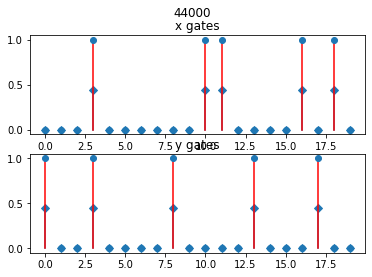

Epoch[44100/50000]: corr: 9.989273071289062, reg: 0.5000110864639282
Epoch[44200/50000]: corr: 9.98607063293457, reg: 0.5000110864639282
Epoch[44300/50000]: corr: 9.989311218261719, reg: 0.5000110864639282
Epoch[44400/50000]: corr: 9.989275932312012, reg: 0.5000109672546387
Epoch[44500/50000]: corr: 9.989341735839844, reg: 0.5000109672546387
Epoch[44600/50000]: corr: 9.988999366760254, reg: 0.5000109076499939
Epoch[44700/50000]: corr: 9.989319801330566, reg: 0.5000108480453491
Epoch[44800/50000]: corr: 9.989296913146973, reg: 0.5000108480453491
Epoch[44900/50000]: corr: 9.98757553100586, reg: 0.5000107884407043
Epoch[45000/50000]: corr: 9.989214897155762, reg: 0.5000107288360596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

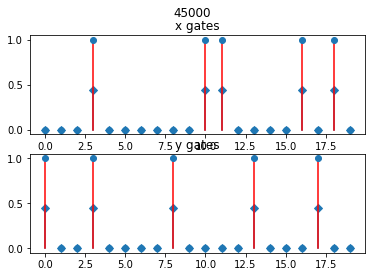

Epoch[45100/50000]: corr: 9.98929214477539, reg: 0.5000107288360596
Epoch[45200/50000]: corr: 9.989333152770996, reg: 0.5000106692314148
Epoch[45300/50000]: corr: 9.98935604095459, reg: 0.5000106692314148
Epoch[45400/50000]: corr: 9.98936939239502, reg: 0.5000105500221252
Epoch[45500/50000]: corr: 9.989362716674805, reg: 0.5000104904174805
Epoch[45600/50000]: corr: 9.9893217086792, reg: 0.5000104904174805
Epoch[45700/50000]: corr: 9.989380836486816, reg: 0.5000104904174805
Epoch[45800/50000]: corr: 9.988838195800781, reg: 0.5000104308128357
Epoch[45900/50000]: corr: 9.989145278930664, reg: 0.5000103712081909
Epoch[46000/50000]: corr: 9.989396095275879, reg: 0.5000103116035461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

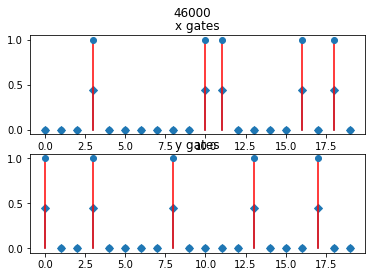

Epoch[46100/50000]: corr: 9.98888111114502, reg: 0.5000102519989014
Epoch[46200/50000]: corr: 9.986879348754883, reg: 0.5000101923942566
Epoch[46300/50000]: corr: 9.989301681518555, reg: 0.5000101327896118
Epoch[46400/50000]: corr: 9.988252639770508, reg: 0.5000101327896118
Epoch[46500/50000]: corr: 9.988096237182617, reg: 0.5000101327896118
Epoch[46600/50000]: corr: 9.989225387573242, reg: 0.5000100135803223
Epoch[46700/50000]: corr: 9.988374710083008, reg: 0.5000100135803223
Epoch[46800/50000]: corr: 9.984764099121094, reg: 0.5000100135803223
Epoch[46900/50000]: corr: 9.98588752746582, reg: 0.5000098943710327
Epoch[47000/50000]: corr: 9.989386558532715, reg: 0.5000098943710327


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

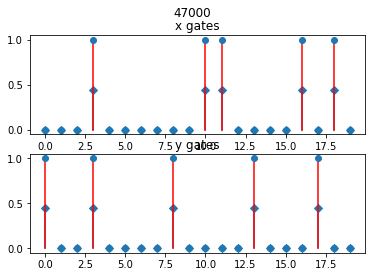

Epoch[47100/50000]: corr: 9.98945140838623, reg: 0.5000098943710327
Epoch[47200/50000]: corr: 9.98947525024414, reg: 0.5000098347663879
Epoch[47300/50000]: corr: 9.988704681396484, reg: 0.5000098347663879
Epoch[47400/50000]: corr: 9.988710403442383, reg: 0.5000097751617432
Epoch[47500/50000]: corr: 9.989439964294434, reg: 0.5000097155570984
Epoch[47600/50000]: corr: 9.989581108093262, reg: 0.5000097155570984
Epoch[47700/50000]: corr: 9.989014625549316, reg: 0.5000096559524536
Epoch[47800/50000]: corr: 9.988373756408691, reg: 0.5000096559524536
Epoch[47900/50000]: corr: 9.989341735839844, reg: 0.5000095963478088
Epoch[48000/50000]: corr: 9.989537239074707, reg: 0.5000095367431641


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

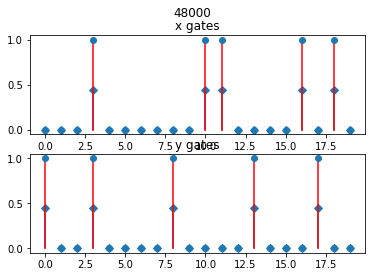

Epoch[48100/50000]: corr: 9.988443374633789, reg: 0.5000094771385193
Epoch[48200/50000]: corr: 9.98923397064209, reg: 0.5000094175338745
Epoch[48300/50000]: corr: 9.98960018157959, reg: 0.5000094175338745
Epoch[48400/50000]: corr: 9.988357543945312, reg: 0.500009298324585
Epoch[48500/50000]: corr: 9.988083839416504, reg: 0.500009298324585
Epoch[48600/50000]: corr: 9.989279747009277, reg: 0.500009298324585
Epoch[48700/50000]: corr: 9.989585876464844, reg: 0.500009298324585
Epoch[48800/50000]: corr: 9.989084243774414, reg: 0.500009298324585
Epoch[48900/50000]: corr: 9.989630699157715, reg: 0.5000092387199402
Epoch[49000/50000]: corr: 9.989704132080078, reg: 0.5000091791152954


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

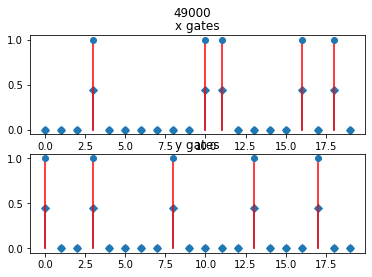

Epoch[49100/50000]: corr: 9.989212989807129, reg: 0.5000091791152954
Epoch[49200/50000]: corr: 9.989367485046387, reg: 0.5000091195106506
Epoch[49300/50000]: corr: 9.989463806152344, reg: 0.5000090599060059
Epoch[49400/50000]: corr: 9.988700866699219, reg: 0.5000090003013611
Epoch[49500/50000]: corr: 9.986156463623047, reg: 0.5000089406967163
Epoch[49600/50000]: corr: 9.988865852355957, reg: 0.5000089406967163
Epoch[49700/50000]: corr: 9.989629745483398, reg: 0.5000089406967163
Epoch[49800/50000]: corr: 9.989587783813477, reg: 0.5000089406967163
Epoch[49900/50000]: corr: 9.989834785461426, reg: 0.5000088214874268
Epoch[50000/50000]: corr: 9.98798656463623, reg: 0.5000088214874268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and s

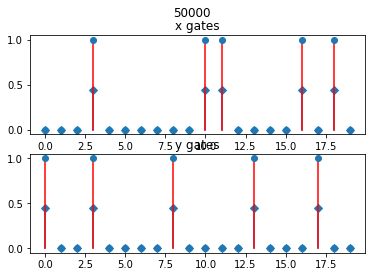

In [22]:
# # from SDCCA import SDCCA
# from utils import plot_gates, gen_data, L2Norm
# from criterions import NegCorr
import torch.nn as nn
import torch.optim as optim
import torch


def create_networks(lamx, sigmax, lamy, sigmay, size):
    f = nn.Sequential(nn.Linear(size, 100, bias=False),
                      nn.ReLU(),
                      nn.Linear(100, 100, bias=False),
                      nn.ReLU(),
                      nn.Linear(100, 10, bias=False),
                      L2Norm())

    g = nn.Sequential(nn.Linear(size, 100, bias=False),
                      nn.ReLU(),
                      nn.Linear(100, 100, bias=False),
                      nn.ReLU(),
                      nn.Linear(100, 10, bias=False),
                      L2Norm())

    net = SDCCA(size, f, lamx, sigmax,
                size, g, lamy, sigmay)

    return net


def train(net, criterion, x, y, gates_optim, func_optim, k):
    net.train()
    if k == 0:
        gates_optim.zero_grad()
    func_optim.zero_grad()

    x_emb, y_emb = net(x, y)
    neg_corr = criterion(x_emb, y_emb)
    reg = net.get_reg()
    loss = neg_corr + reg
    loss.backward()

    func_optim.step()
    if k == 0:
        gates_optim.step()

    return neg_corr.item(), reg.item()


def simple_train(net, criterion, x, y, optimizer):
    net.train()
    optimizer.zero_grad()

    x_emb, y_emb = net(x, y)
    neg_corr = criterion(x_emb, y_emb)
    reg = net.get_reg()
    loss = neg_corr + reg
    loss.backward()

    optimizer.step()

    return neg_corr.item(), reg.item()


def main():
    device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
    # device = torch.device("cpu")
    lamx = 5e-2
    lamy = 1e-5
    sigmax = 1.0
    sigmay = 1.0
    lamy = lamx  # TODO: remove after tests

    samples = 1000
    size = 20

    epochs = 50000
    K = 10

    x, y, u, v, _ = gen_data(samples, size, size)
    x = torch.tensor(x, device=device, dtype=torch.float32)
    y = torch.tensor(y, device=device, dtype=torch.float32)

    net = create_networks(lamx, sigmax, lamy, sigmay, size).to(device)

    criterion = NegCorr(device)
    gates_optimizer = optim.Adam(net.get_gates_parameters(), lr=1e-1)
    funcs_optimizer = optim.Adam(net.get_function_parameters(), lr=1e-4)
    for epoch in range(epochs):
        neg_corr, reg = train(net, criterion, x, y, gates_optimizer, funcs_optimizer, (epoch+1)%K)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{epochs}]: corr: {-neg_corr}, reg: {reg}')
        if (epoch + 1) % 1000 == 0:
            plot_gates(net, epoch+1, u, v)


if __name__ == '__main__':
    main()